In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Normalize the images to [0, 1] range
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

# Flatten the images to vectors of size 784
x_train = x_train.reshape(-1, 28 * 28)
x_test = x_test.reshape(-1, 28 * 28)

# Convert labels to categorical (one-hot encoding)
num_classes = 10
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)


In [5]:
def build_model(hp):
    model = keras.Sequential()
    # Input layer
    model.add(layers.InputLayer(input_shape=(784,)))

    # Hyperparameter: Number of hidden layers
    num_hidden = hp.Int('num_hidden_layers', min_value=1, max_value=5, step=1)

    for i in range(num_hidden):
        # Hyperparameter: Units in each hidden layer
        units = hp.Int(f'units_{i}', min_value=32, max_value=512, step=32)
        model.add(layers.Dense(units, activation='relu'))
        # Optionally, add dropout for regularization
        dropout_rate = hp.Float('dropout_rate', 0.0, 0.5, step=0.1)
        if dropout_rate > 0:
            model.add(layers.Dropout(dropout_rate))

    # Output layer
    model.add(layers.Dense(num_classes, activation='softmax'))

    # Hyperparameter: Learning rate
    learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    # Compile the model
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


In [6]:
import keras_tuner as kt

# Define the tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=20,  # Number of different hyperparameter combinations to try
    executions_per_trial=1,  # Number of models to build and fit for each trial
    directory='kt_dir',
    project_name='mnist_mlp_random_search'
)

# Display search space summary
tuner.search_space_summary()


Search space summary
Default search space size: 4
num_hidden_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 5, 'step': 1, 'sampling': 'linear'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
dropout_rate (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [7]:
# Define early stopping to prevent overfitting
stop_early = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# Start the hyperparameter search
tuner.search(
    x_train,
    y_train,
    epochs=50,  # Set a high number; early stopping will handle stopping
    validation_split=0.2,
    callbacks=[stop_early],
    verbose=1
)

# Display a summary of the search results
tuner.results_summary()


Trial 20 Complete [00h 02m 39s]
val_accuracy: 0.9785833358764648

Best val_accuracy So Far: 0.9819999933242798
Total elapsed time: 00h 46m 05s
Results summary
Results in kt_dir\mnist_mlp_random_search
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 04 summary
Hyperparameters:
num_hidden_layers: 1
units_0: 480
dropout_rate: 0.4
learning_rate: 0.0001
units_1: 416
units_2: 416
units_3: 352
units_4: 64
Score: 0.9819999933242798

Trial 02 summary
Hyperparameters:
num_hidden_layers: 1
units_0: 224
dropout_rate: 0.30000000000000004
learning_rate: 0.001
units_1: 192
units_2: 448
units_3: 224
units_4: 480
Score: 0.9815833568572998

Trial 08 summary
Hyperparameters:
num_hidden_layers: 3
units_0: 320
dropout_rate: 0.1
learning_rate: 0.0001
units_1: 192
units_2: 32
units_3: 64
units_4: 480
Score: 0.9799166917800903

Trial 09 summary
Hyperparameters:
num_hidden_layers: 1
units_0: 160
dropout_rate: 0.2
learning_rate: 0.0001
units_1: 128
units_2: 64
units_3: 32
units_4: 

In [8]:
# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Best Hyperparameters:")
print(f"Number of Hidden Layers: {best_hps.get('num_hidden_layers')}")
for i in range(best_hps.get('num_hidden_layers')):
    print(f"Units in Hidden Layer {i+1}: {best_hps.get(f'units_{i}')}")
print(f"Dropout Rate: {best_hps.get('dropout_rate')}")
print(f"Learning Rate: {best_hps.get('learning_rate')}")

# Build the best model
model = tuner.hypermodel.build(best_hps)

# Train the best model
history = model.fit(
    x_train,
    y_train,
    epochs=50,
    validation_split=0.2,
    callbacks=[stop_early],
    verbose=1
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)
print(f"\nTest Accuracy: {test_accuracy:.4f}")


Best Hyperparameters:
Number of Hidden Layers: 1
Units in Hidden Layer 1: 480
Dropout Rate: 0.4
Learning Rate: 0.0001
Epoch 1/50
1500/1500 [==============================] - 13s 8ms/step - loss: 0.5988 - accuracy: 0.8393 - val_loss: 0.2857 - val_accuracy: 0.9238
Epoch 2/50
1500/1500 [==============================] - 11s 8ms/step - loss: 0.2923 - accuracy: 0.9169 - val_loss: 0.2198 - val_accuracy: 0.9412
Epoch 3/50
1500/1500 [==============================] - 12s 8ms/step - loss: 0.2319 - accuracy: 0.9347 - val_loss: 0.1837 - val_accuracy: 0.9503
Epoch 4/50
1500/1500 [==============================] - 11s 8ms/step - loss: 0.1953 - accuracy: 0.9451 - val_loss: 0.1585 - val_accuracy: 0.9565
Epoch 5/50
1500/1500 [==============================] - 12s 8ms/step - loss: 0.1680 - accuracy: 0.9523 - val_loss: 0.1405 - val_accuracy: 0.9602
Epoch 6/50
1500/1500 [==============================] - 12s 8ms/step - loss: 0.1475 - accuracy: 0.9574 - val_loss: 0.1288 - val_accuracy: 0.9631
Epoch 7/50
1

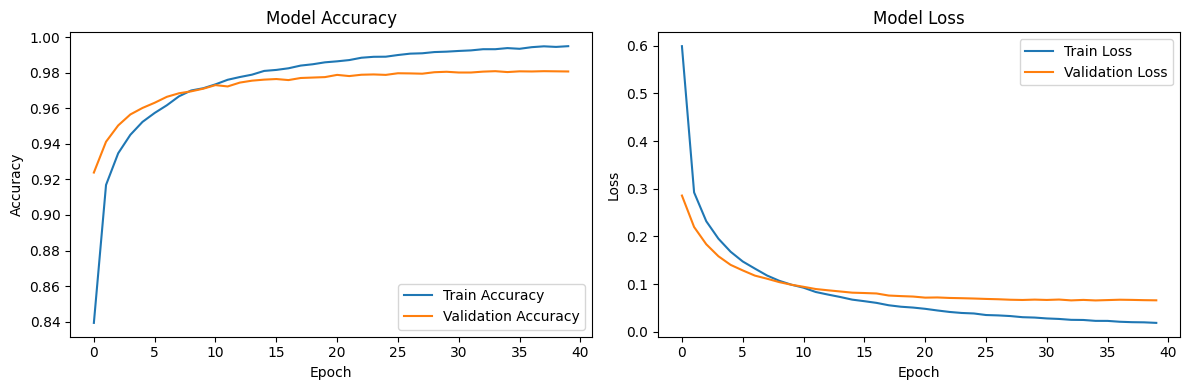

In [9]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()
